In [97]:
import numpy as np
import matplotlib.pyplot as plt
import os

from sklearn.preprocessing import StandardScaler
import GPy

In [98]:
os.chdir('/home/saumya/Documents/Flame_dianostics-temperature_profile_estimation_using_ML-main/spec_data/New_final')

In [99]:
x_dat = np.load('ABS_noisy_SNR_new.npy').astype(np.half)
# x_dat = np.reshape(x_dat, -1)[:, None]

In [100]:
x_dat.shape

(12500, 3000)

In [101]:
x_dat

array([[3.600e-05, 3.844e-05, 2.837e-05, ..., 4.733e-05, 5.478e-05,
        4.387e-05],
       [2.068e-05, 2.652e-05, 2.497e-05, ..., 6.682e-05, 7.761e-05,
        5.633e-05],
       [1.049e-05, 4.423e-05, 2.927e-05, ..., 7.147e-05, 1.000e-04,
        7.272e-05],
       ...,
       [9.294e-04, 7.172e-04, 2.909e-05, ..., 7.749e-04, 3.695e-04,
        5.455e-04],
       [2.177e-04, 8.788e-04, 4.585e-04, ..., 5.589e-04, 7.362e-04,
        8.240e-04],
       [8.302e-04, 3.266e-04, 6.490e-04, ..., 9.861e-04, 4.880e-04,
        7.000e-04]], dtype=float16)

In [102]:
os.chdir('/home/saumya/Documents/data/snr')

In [103]:
y_dat_std = np.load('param_SNR.npy')

# y_dat = np.reshape(y_dat, -1)[:, None]

# y_dat = y_dat[:10000]

In [104]:
y_dat_std.shape

(12500, 3)

In [105]:
y_A1_T = StandardScaler().fit(np.reshape(y_dat_std[:,0],-1)[:,None])
y_A2_T = StandardScaler().fit(np.reshape(y_dat_std[:,1],-1)[:,None])
y_A3_T = StandardScaler().fit(np.reshape(y_dat_std[:,2],-1)[:,None])

In [106]:
y_A1_d = y_A1_T.transform(np.reshape(y_dat_std[:,0],-1)[:,None])
y_A2_d = y_A2_T.transform(np.reshape(y_dat_std[:,1],-1)[:,None])
y_A3_d = y_A3_T.transform(np.reshape(y_dat_std[:,2],-1)[:,None])

In [107]:
y_dat = np.column_stack((y_A1_d, y_A2_d, y_A3_d))

In [108]:
# import pickle

# import pickle
# with open('y_d_T_ICM.pkl', 'wb') as file:
#     pickle.dump(y_dat_transform, file)

In [109]:
from sklearn.model_selection import train_test_split

In [110]:
def train_val_test_split(X, y, val_size):
    # test_size = 1 - train_size - val_size
    X_train_val, X_test, y_train_val, y_test = train_test_split(X, y, test_size = val_size)
    # relative_train_size = train_size / (val_size + train_size)
    # X_train, X_val, y_train, y_val = train_test_split(X_train_val, y_train_val,
                                                    #   train_size = relative_train_size, test_size = 1-relative_train_size)
    return X_train_val, X_test, y_train_val, y_test

In [111]:
X_train, X_test, Y_train, Y_test = train_val_test_split(x_dat, y_dat, .2)

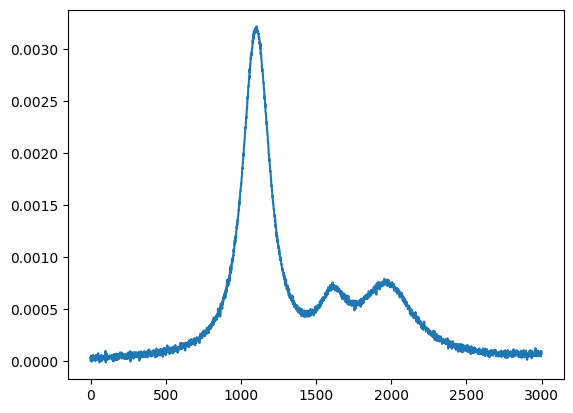

In [112]:
plt.plot(x_dat[2])

In [113]:
# ICM model set up
ks = GPy.kern.RBF(np.shape(X_train)[1])
icm = GPy.util.multioutput.ICM(input_dim=np.shape(X_train)[1],num_outputs=3,kernel=ks)

In [114]:
print(icm)
# print('W matrix\n',icm.B.W)
# print('\nkappa vector\n',icm.B.kappa)
# print('\nB matrix\n',icm.B.B)

  ICM.             |   value  |  constraints  |  priors
  rbf.variance     |     1.0  |      +ve      |        
  rbf.lengthscale  |     1.0  |      +ve      |        
  B.W              |  (3, 1)  |               |        
  B.kappa          |    (3,)  |      +ve      |        


In [115]:
Y_train.shape

(10000, 3)

In [116]:
[np.reshape(Y_train[:, 0],-1)[:,None], np.reshape(Y_train[:, 1],-1)[:,None], np.reshape(Y_train[:, 2],-1)[:,None]]

[array([[ 1.697 ],
        [ 0.3105],
        [ 1.629 ],
        ...,
        [ 0.9355],
        [-1.004 ],
        [ 1.697 ]], dtype=float16),
 array([[ 1.415e+00],
        [-7.070e-01],
        [-7.070e-01],
        ...,
        [ 7.070e-01],
        [-7.070e-01],
        [-2.747e-04]], dtype=float16),
 array([[ 0.6577],
        [ 0.866 ],
        [ 1.351 ],
        ...,
        [-1.559 ],
        [ 0.797 ],
        [ 1.698 ]], dtype=float16)]

In [117]:
m = GPy.models.GPCoregionalizedRegression([X_train, X_train, X_train],[np.reshape(Y_train[:, 0],-1)[:,None], np.reshape(Y_train[:, 1],-1)[:,None], np.reshape(Y_train[:, 2],-1)[:,None]],kernel=icm)
m['.*rbf.var'].constrain_fixed(1.)
# constrain if converge to reasonless extrema
# m['mixed_noise.Gaussian_noise_0.variance'].constrain_bounded(0,1e-5)
# m['mixed_noise.Gaussian_noise_1.variance'].constrain_bounded(0,1e-5)
# m['mixed_noise.Gaussian_noise_2.variance'].constrain_bounded(0,1e-5)
print(m)

In [ ]:
# print('W matrix\n',icm.B.W)
# print('\nkappa vector\n',icm.B.kappa)

In [ ]:
m.optimize(messages=True)

In [ ]:
import pickle

import pickle
with open('gpr_ICM_Norm.pkl', 'wb') as file:
    pickle.dump(m, file)

In [ ]:
print(m)
# print('W matrix\n',icm.B.W)
# print('\nkappa vector\n',icm.B.kappa)
# print('\nB matrix\n',icm.B.B)


Name : gp
Objective : 140485.1539718978
Number of Parameters : 5
Number of Optimization Parameters : 4
Updates : True
Parameters:
  gp.                                    |                value  |  constraints  |  priors
  ICM.rbf.variance                       |                  1.0  |   +ve fixed   |        
  ICM.rbf.lengthscale                    |  0.03722498388015428  |      +ve      |        
  ICM.B.W                                |        [83.28557061]  |               |        
  ICM.B.kappa                            |   10.273656984369074  |      +ve      |        
  mixed_noise.Gaussian_noise_0.variance  |    534.6913479619705  |      +ve      |        


In [ ]:
newX = X_test

In [ ]:
newX = np.concatenate((newX,np.zeros((np.shape(X_test)[0],1))),1)
noise_dict = {'output_index':newX[:,-1].astype(int)}
ys,var=m.predict(newX,Y_metadata=noise_dict)

# Temper_test_=scalerT.inverse_transform(ys)


In [ ]:
ys

array([[6.94948480e+02, 5.64528744e-01, 5.30986248e+01],
       [7.16096772e+02, 5.42070440e-01, 2.12604508e+01],
       [4.75126111e+02, 5.26678502e-01, 4.01581732e+01],
       ...,
       [6.58390126e+02, 4.56907873e-01, 8.84262548e+00],
       [7.14161336e+02, 4.99538674e-01, 3.66491511e+01],
       [7.41888336e+02, 4.68136992e-01, 1.01914647e+01]])

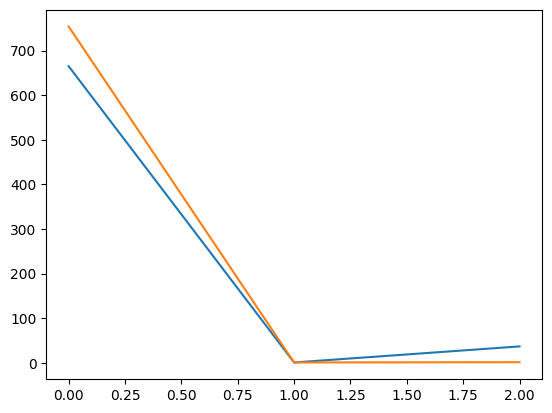

In [ ]:
plt.plot(ys[1030])

plt.plot(Y_train[1030])

In [ ]:
ys

array([[6.94948480e+02, 5.64528744e-01, 5.30986248e+01],
       [7.16096772e+02, 5.42070440e-01, 2.12604508e+01],
       [4.75126111e+02, 5.26678502e-01, 4.01581732e+01],
       ...,
       [6.58390126e+02, 4.56907873e-01, 8.84262548e+00],
       [7.14161336e+02, 4.99538674e-01, 3.66491511e+01],
       [7.41888336e+02, 4.68136992e-01, 1.01914647e+01]])

In [ ]:
Y_test

array([[6.965e+02, 7.524e-01, 5.275e+01],
       [7.155e+02, 5.049e-01, 2.133e+01],
       [4.758e+02, 5.049e-01, 3.928e+01],
       ...,
       [6.965e+02, 1.000e+00, 6.734e+00],
       [7.060e+02, 1.000e-02, 3.703e+01],
       [7.635e+02, 7.524e-01, 8.977e+00]], dtype=float16)

In [ ]:
from sklearn import metrics

In [ ]:
conc_1 = metrics.mean_squared_error(np.array(ys[:, 1]), np.array(Y_test[:, 1]))
print(f'The mean squared error between the real and predicted values are: {conc_1}')

The mean squared error between the real and predicted values are: 0.11790001785121622


In [ ]:
conc_1 = metrics.mean_squared_error(np.array(ys[:, 2]), np.array(Y_test[:, 2]))
print(f'The mean squared error between the real and predicted values are: {conc_1}')

The mean squared error between the real and predicted values are: 31.84078213933334


In [ ]:
conc_1 = metrics.mean_squared_error(np.array(ys[:, 0]), np.array(Y_test[:, 0]))
print(f'The mean squared error between the real and predicted values are: {conc_1}')

The mean squared error between the real and predicted values are: 1240.1513804856372


In [ ]:
metrics.mean_squared_error(ys, Y_test)

424.0366875476064